# Part 2 - Plotting neutron energy spectra in a cell with progressively improved plotting and tallying techniques

This example creates a simple sphere of water and tallies neutron energy distribution averaged across a couple of cell.

linear spaced energy bins from 0MeV to 15MeV, then group structure, then lethargy

In [ ]:
from IPython.display import IFrame
IFrame(src="https://www.youtube.com/embed/qHqAuqMLYPA", width=560, height=340)

This section creates a simple material, geometry and settings. This model is used in both the neutron current tally and the neutron flux tally.

In [1]:
import openmc
import numpy as np
import matplotlib.pyplot as plt

# MATERIALS
openmc.config['cross_sections'] = '/home/nuclearkid/openmc_conda/openmc_data/endfb80/endfb-viii.0-hdf5/cross_sections.xml'
# Due to the hydrogen content water is a very good neutron moderator
my_material = openmc.Material()
my_material.add_element('H', 2, percent_type='ao')
my_material.add_element('O', 1, percent_type='ao')
my_material.set_density('g/cm3', 1)

my_materials = openmc.Materials([my_material])


# GEOMETRY

# surfaces
outer_surface = openmc.Sphere(r=100, boundary_type='vacuum')

# cells
cell_1 = openmc.Cell(region=-outer_surface)
cell_1.fill = my_material

my_geometry = openmc.Geometry([cell_1])


# SIMULATION SETTINGS

# Instantiate a Settings object
my_settings = openmc.Settings()
my_settings.batches = 10
my_settings.particles = 10000
my_settings.run_mode = 'fixed source'

# Create a DT point source
my_source = openmc.IndependentSource()
my_source.space = openmc.stats.Point((0, 0, 0))
my_source.angle = openmc.stats.Isotropic()
my_source.energy = openmc.stats.Discrete([14e6], [1])
my_settings.source = my_source

This section section adds a tally for the average neutron flux across a cell.

In [2]:
# sets up filters for the tallies
neutron_particle_filter = openmc.ParticleFilter(['neutron'])

# creates an array of 709 linear spaced energy bins from 0MeV to 15MeV
# our source is 14MeV so this should capture all the neutron energies in the simulation
# there is a disadvantage of using a linear group structure which is covered later in this task
energy_filter = openmc.EnergyFilter(np.linspace(0, 15e6, 719))

# setup the filters for the cell tally
cell_filter = openmc.CellFilter([cell_1]) 

# create the tally
cell_spectra_tally = openmc.Tally(name='cell_spectra_tally')
cell_spectra_tally.scores = ['flux']
cell_spectra_tally.filters = [cell_filter, neutron_particle_filter, energy_filter]
my_tallies = openmc.Tallies([cell_spectra_tally])

This section runs the simulation.

In [3]:
# combine all the required parts to make a model
model = openmc.model.Model(my_geometry, my_materials, my_settings, my_tallies)

# remove old files and runs OpenMC
!rm *.h5
results_filename = model.run()

[juan-ASUS-TUF-Gaming-F15:13609] shmem: mmap: an error occurred while determining whether or not /tmp/ompi.juan-ASUS-TUF-Gaming-F15.1000/jf.0/2803630080/shared_mem_cuda_pool.juan-ASUS-TUF-Gaming-F15 could be created.
[juan-ASUS-TUF-Gaming-F15:13609] create_and_attach: unable to create shared memory BTL coordinating structure :: size 134217728 
                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
          

This section extracts the cell tally data from the results file and plots neutron flux across the cell. Selecting log-log scale will allow you to see a distribution of thermal neutrons.

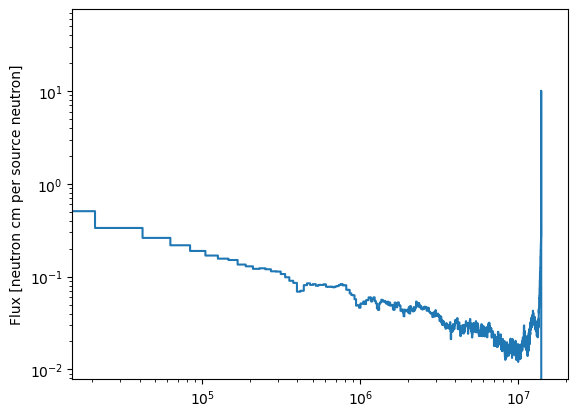

In [4]:
# open the results file
results = openmc.StatePoint(results_filename)

#extracts the tally values from the simulation results
cell_tally = results.get_tally(name='cell_spectra_tally')

# flattens the ndarray into a 1d array
flux = cell_tally.mean.flatten()

plt.figure()
 # trim the last energy filter bin edge to make the number of x and y values the same
plt.step(energy_filter.values[:-1], flux)
plt.yscale('log')
plt.xscale('log')
plt.ylabel('Flux [neutron cm per source neutron]')  # these are not ideal units but part 3 improves the units
plt.show()

This plot is not particularly good as the uniform bin width means we don't see all the details in the neutron spectra.

We can improve the simulation by using bins that are spaced to capture details in certain parts of the spectra (e.g. thermal neutron energies) 

This next cell replaces the tally with a spectra tally that makes use of a predefined group structure

In [5]:
# creates an array of energy bins to use for the tally
# these are not linearly spaced as they have extra bins in key energy ranges
# A full list of energy structures is available here
# https://github.com/openmc-dev/openmc/blob/6254be37582e09acff038f5656332b89e53e4eae/openmc/mgxs/__init__.py#L50-L420
energy_filter = openmc.EnergyFilter.from_group_structure('CCFE-709')

# setup the filters for the cell tally
cell_filter = openmc.CellFilter([cell_1]) 

# create the tally
cell_spectra_tally = openmc.Tally(name='cell_spectra_tally')
cell_spectra_tally.scores = ['flux']
cell_spectra_tally.filters = [cell_filter, neutron_particle_filter, energy_filter]
my_tallies = openmc.Tallies([cell_spectra_tally])

This remakes the model wit the new energy filter in the tally and reruns the simulation

In [6]:
# combine all the required parts to make a model
model = openmc.model.Model(my_geometry, my_materials, my_settings, my_tallies)

# remove old files and runs OpenMC
!rm *.h5
results_filename = model.run()

[juan-ASUS-TUF-Gaming-F15:13652] shmem: mmap: an error occurred while determining whether or not /tmp/ompi.juan-ASUS-TUF-Gaming-F15.1000/jf.0/3031957504/shared_mem_cuda_pool.juan-ASUS-TUF-Gaming-F15 could be created.
[juan-ASUS-TUF-Gaming-F15:13652] create_and_attach: unable to create shared memory BTL coordinating structure :: size 134217728 
                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
          

This extracts the result and plots the spectrum

additionally the units are converted to n/cm2-s

The thermal neutron distribution is now much more visible

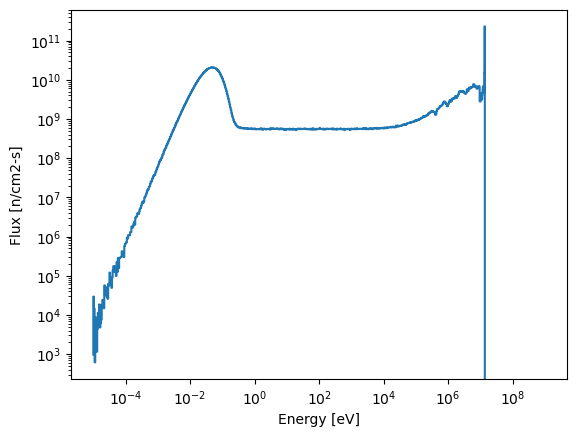

In [7]:
# open the results file
results = openmc.StatePoint(results_filename)

#extracts the tally values from the simulation results
cell_tally = results.get_tally(name='cell_spectra_tally')

# flattens the ndarray into a 1d array for plotting
openmc_flux = cell_tally.mean.flatten()

volume_of_cell = 5.24e8 # in units of cm3
reactor_power = 500e6  # in units of watts
energy_of_each_fusion_reaction = 17.5e6 * 2.8e-18  # eV converted to Joules
neutrons_per_second = reactor_power / energy_of_each_fusion_reaction

flux = (openmc_flux / volume_of_cell) * neutrons_per_second # divide by cell volume and then multiply by source strength

plt.figure()
 # trim the last energy filter bin edge to make the number of x and y values the same
plt.step(energy_filter.values[:-1], flux)
plt.xscale('log')
plt.yscale('log')
plt.ylabel('Flux [n/cm2-s]')
plt.xlabel('Energy [eV]')
plt.show()

We can go one step further and scale with lethargy
Background reading links
https://gaussling.wordpress.com/2008/05/15/neutron-lethargy-this-weeks-obscure-dimensionless-quantity/
https://www.ornl.gov/file/plotting-flux-spectra-keno/display
http://profjrwhite.com/rphys_course/NRTlecture_files/NRT_Lesson1_ThmFluxSpectrum.pdf

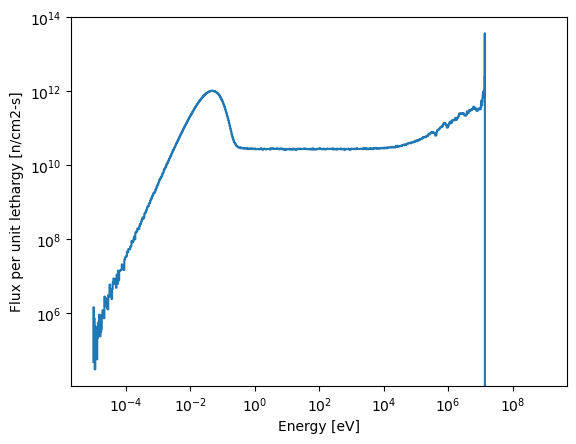

In [8]:
bin_boundaries = energy_filter.lethargy_bin_width
norm_flux = flux / bin_boundaries

plt.figure()
 # trim the last energy filter bin edge to make the number of x and y values the same
plt.step(energy_filter.values[:-1], norm_flux)
plt.yscale('log')
plt.xscale('log')
plt.ylabel('Flux per unit lethargy [n/cm2-s]')
plt.xlabel('Energy [eV]')
plt.show()

#### Additional notes

- When comparing these results with other codes it might be necessary to scale them:
    - The OpenMC cell flux needs to be divided by the cell volume when comparing with MCNP.


**Learning Outcomes for Part 1:**

- Neutron spectra can be tallied in OpenMC using flux tallies, and energy bins.
- Neutron spectra need to be recorded on energy grids with specific structure if the details are to be highlighted
- Neutron energy tend to decrease as a function of depth in the materials as they neutrons are down scattered